In [80]:
from datetime import datetime
from multiprocessing import Pool

import time
import os
import sys
from pathlib import Path

import numpy as np
import scipy
import pandas as pd
import matplotlib
matplotlib.use('nbagg')
from matplotlib import style
style.use('ggplot')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

from astropy import stats

import astropy.units as u
from astropy.io import fits
from mmtwfs.wfs import WFSFactory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [125]:
# instantiate all of the WFS systems...
wfs_keys = ['newf9', 'f5', 'mmirs', 'binospec']
wfs_systems = {}
wfs_names = {}
for w in wfs_keys:
    wfs_systems[w] = WFSFactory(wfs=w)
    wfs_names[w] = wfs_systems[w].name
plt.close('all')

# it appears the binospec reference LED doesn't use a pinhole so the reference spots are smeared out. as a hack
# we'll assume the spots are nyquist sampled like the f5 and mmirs systems.
wfs_systems['binospec'].modes['binospec']['reference']['fwhm'] = 2.0
wfs_systems['binospec'].modes['binospec']['reference']['sigma'] = 2.0 * stats.funcs.gaussian_fwhm_to_sigma

# give mmirs a default
wfs_systems['mmirs'].default_mode = 'mmirs1'

In [128]:
def seeing(df, wfs):
    """
    Given a sigma derived from a gaussian fit to a WFS spot, deconvolve the systematic width from the reference image
    and relate the remainder to r_0 and thus a seeing FWHM.
    """
    # the effective wavelength of the WFS imagers is about 600-650 nm. we use 650 nm to maintain consistency
    # with the value used by the old SHWFS system.
    wave = 650 * u.nm
    wave = wave.to(u.m).value  # r_0 equation expects meters so convert

    mode = wfs.default_mode
    
    # calculate the physical size of each aperture.
    ref = wfs.modes[mode]['reference']
    apsize_pix = np.max((ref['xspacing'], ref['yspacing']))
    d = wfs.telescope.diameter * apsize_pix / wfs.pup_size
    d = d.to(u.m).value  # r_0 equation expects meters so convert

    # we need to deconvolve the instrumental spot width from the measured one to get the portion of the width that
    # is due to spot motion
    ref_sigma = stats.funcs.gaussian_fwhm_to_sigma * ref['fwhm']
    sigma = stats.funcs.gaussian_fwhm_to_sigma * df['fwhm']
    
    corr_sigma = np.sqrt(sigma**2 - ref_sigma**2)
    corr_sigma *= wfs.pix_size.to(u.rad).value  # r_0 equation expects radians so convert

    # this equation relates the motion within a single aperture to the characteristic scale size of the
    # turbulence, r_0.
    r_0 = ( 0.179 * (wave**2) * (d**(-1/3))/corr_sigma**2 )**0.6

    # this equation relates the turbulence scale size to an expected image FWHM at the given wavelength.
    raw_seeing = u.Quantity(u.rad * 0.98 * wave / r_0, u.arcsec)

    # correct seeing to zenith
    seeing = raw_seeing / df['airmass']**0.6

    return raw_seeing, seeing

In [64]:
def check_wfs(p):
    """
    Check to see which system was used on a given night
    """
    if Path.exists(p / "F9"):  # wow, i really like pathlib.Path...
        return "newf9"
    elif Path.exists(p / "F5"):
        return "f5"
    elif Path.exists(p / "MMIRS"):
        return 'mmirs'
    else:
        return None

def process_image(f, wfskey=None):
    """
    Process FITS file, f, to get info we want from the header and then analyse it with the 
    appropriate WFS instance. Return results in a comma-separated line that will be collected 
    and saved in a CSV file.
    """
    if "ave" not in f.name:
        with fits.open(f) as h:
            hdr = h[-1].header
            
            # if wfskey is None, figure out which WFS from the header info...
            if wfskey is None:
                # check for MMIRS
                if 'WFSNAME' in hdr:
                    if 'mmirs' in hdr['WFSNAME']:
                        wfskey = 'mmirs'
                if 'mmirs' in f.name:
                    wfskey = 'mmirs'
                    
                # check for binospec
                if 'bino' in f.name:
                    wfskey = 'binospec'
                if 'ORIGIN' in hdr:
                    if 'Binospec' in hdr['ORIGIN']:
                        wfskey = 'binospec'
                        
                # check for F/9
                if 'f9wfs' in f.name:
                    wfskey = 'newf9'
                if 'OBSERVER' in hdr:
                    if 'F/9 WFS' in hdr['OBSERVER']:
                        wfskey = 'newf9'
                if wfskey is None and 'CAMERA' in hdr:
                    if 'F/9 WFS' in hdr['CAMERA']:
                        wfskey = 'newf9'
                        
                # check for F/5 (hecto)
                if wfskey is None and 'SEC' in hdr:  # mmirs has SEC in header as well and is caught above
                    if 'F5' in hdr['SEC']:
                        wfskey = 'f5'
                        
            if wfskey is None:
                # if wfskey is still None at this point, bail out.
                print(f"Can't determine WFS for {f.name}...")
                return None
            # else:
                # print(f"Using {wfskey} for {f.name}...")

            if 'AIRMASS' in hdr:
                airmass = hdr['AIRMASS']
            else:
                airmass = np.nan

            # we need to fix the headers in all cases to have a proper DATE-OBS entry with
            # properly formatted FITS timestamp.  in the meantime, this hack gets us what we need 
            # for analysis in pandas.
            dtime = None
            if 'DATEOBS' in hdr:
                dateobs = hdr['DATEOBS']
                ut = hdr['ut']
                timestring = dateobs + " " + ut + " UTC"
                if wfskey == 'newf9':
                    dtime = datetime.strptime(timestring, "%a %b %d %Y %H:%M:%S %Z")
                else:
                    dtime = datetime.strptime(timestring, "%Y-%m-%d %H:%M:%S %Z")
            else:
                timestring = hdr['DATE-OBS'] + " UTC"
                try:
                    dtime = datetime.strptime(timestring, "%Y-%m-%dT%H:%M:%S.%f %Z")
                except:
                    dtime = datetime.strptime(timestring, "%Y-%m-%dT%H:%M:%S %Z")
                
            if dtime is None:
                print(f"No valid timestamp in header for {f.name}...")
                return None
            else:
                obstime = dtime.isoformat()
                
            # being conservative here and only using data that has proper slope determination
            # and wavefront solution. also want to get statistics on the quality of the wavefront fits.
            try:
                results = wfs_systems[wfskey].measure_slopes(str(f), plot=False)
            except:
                print(f"Problem analyzing {f.name}...")
                results = {}
                results['slopes'] = None

            if results['slopes'] is not None:
                zresults = wfs_systems[wfskey].fit_wavefront(results, plot=False)
                line = "%s,%s,%s,%f,%f,%f,%f,%f\n" % (
                    obstime,
                    wfskey,
                    f.name, 
                    airmass,
                    results['seeing'].value,
                    results['raw_seeing'].value,
                    results['fwhm'],
                    zresults['residual_rms'].value
                )
                zfile = f.parent / (f.stem + ".zernike")
                zresults['zernike'].save(filename=zfile)
                return line
            else:
                return None
    return None
#rootdir = Path("/Users/tim/MMT/wfsdat/test")
#rootdir = Path("/Volumes/LaCie/wfsdat")
rootdir = Path("/Volumes/G-DRIVE mobile USB-C/wfsdat")

In [102]:
dirs = rootdir.glob("20171*")  # pathlib, where have you been all my life!
csv_header = "time,wfs,file,airmass,seeing,raw seeing,fwhm,wavefront rms\n"
for d in dirs:
    if d.is_dir():
        if Path.exists(d / "seeing_results.csv"):
            print("Already processed %s..." % d.name)
        else:
            try:
                lines = []
                lines.append(csv_header)
                night = int(d.name)  # valid WFS directories are ints of the form YYYYMMDD. if not this form, int barfs
                msg = "checking %d... " % night
                fitsfiles = d.glob("*.fits")
                print(msg)
                #for f in fitsfiles:
                #   print("Processing %s..." % f)
                #    process_image(f)
                with Pool(processes=8) as pool:  # my mac's i7 has 4 cores + hyperthreading so 8 virtual cores. 
                    plines = pool.map(process_image, fitsfiles)  # plines comes out in same order as fitslines!
                plines = list(filter(None.__ne__, plines))  # trim out any None entries
                lines.extend(plines)
                with open(d / "seeing_results.csv", "w") as f:
                    f.writelines(lines)
            except ValueError as e:  # this means running int(d.name) failed so it's not a valid directory...
                print(f"Skipping %s... ({e})" % d.name)

Already processed 20171001...
Already processed 20171003...
Already processed 20171004...
Already processed 20171005...
Already processed 20171006...
Already processed 20171007...
Already processed 20171008...
Already processed 20171009...
Already processed 20171010...
Already processed 20171011...
Already processed 20171012...
Already processed 20171013...
Already processed 20171014...
Already processed 20171015...
Already processed 20171016...
Already processed 20171017...
Already processed 20171018...
Already processed 20171019...
Already processed 20171020...
Already processed 20171021...
Already processed 20171022...
Already processed 20171023...
Already processed 20171024...
Already processed 20171025...
Already processed 20171026...
Already processed 20171027...
Already processed 20171028...
Already processed 20171029...
Already processed 20171030...
Already processed 20171031...
Already processed 20171101...
Already processed 20171102...
Already processed 20171103...
Already pr

In [115]:
# use find to make this csv list
with open(rootdir / "csvs_2017q4.txt") as f:
    csvs = f.readlines()

# loop through the csv files and read them with pandas
frames = []
for csv in csvs:
    frames.append(pd.read_csv(csv.rstrip()))

# now concat each frame into one big frame containing all of the data
data = pd.concat(frames)

In [116]:
g = data.groupby('wfs')
g.wfs.describe()

,count,unique,top,freq
wfs,,,,
binospec,11099,1,binospec,11099
f5,176,1,f5,176
mmirs,4136,1,mmirs,4136
newf9,458,1,newf9,458


In [166]:
# re-calculate the seeing using updated spot FWHM for binospec. filter out any NaN values...
fixed_list = []
for wfskey, group in g:
    wfs = wfs_systems[wfskey]
    group = g.get_group(wfskey)
    #group.apply(seeing, axis=1, args=(wfs,))
    group['fixed_raw_seeing'], group['fixed_seeing'] = seeing(group, wfs)
    fixed_list.append(group)
fixed = pd.concat(fixed_list)
fixed.rename(index=str, columns={"seeing": "orig_seeing", "raw seeing": "orig_raw_seeing"}, inplace=True)
fixed.rename(index=str, columns={"fixed_seeing": "seeing", "fixed_raw_seeing": "raw seeing"}, inplace=True)
fixed = fixed[np.isfinite(fixed['seeing'])]

/Users/tim/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/tim/conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


In [167]:
fixed.sort_values(by='seeing')

,time,wfs,file,airmass,orig_seeing,orig_raw_seeing,fwhm,wavefront rms,raw seeing,seeing
14,2017-11-25T07:10:08,newf9,manual_wfs_0014.fits,1.1000,0.380415,0.402803,5.419717,120.897424,0.402803,0.380415
147,2017-10-30T06:19:58,mmirs,mmirs_wfs_0149.fits,1.0300,0.376922,0.383667,3.186117,1531.079079,0.387945,0.381126
115,2017-10-30T03:02:32,mmirs,mmirs_wfs_0116.fits,1.5400,0.387234,0.501749,3.648330,152.638450,0.502656,0.387934
111,2017-10-30T02:59:57,mmirs,mmirs_wfs_0112.fits,1.5300,0.390005,0.503367,3.654785,187.021837,0.504232,0.390675
706,2017-11-13T07:09:15,binospec,bino_wfs_0946.fits,1.1902,0.000000,0.000000,3.286042,868.215732,0.437628,0.394215
577,2017-11-13T06:21:25,binospec,bino_wfs_0817.fits,1.1674,0.000000,0.000000,3.274066,10642.304086,0.434587,0.396045
546,2017-11-13T06:13:57,binospec,bino_wfs_0786.fits,1.1685,0.000000,0.000000,3.277125,899.138151,0.435364,0.396529
189,2017-10-15T03:52:02,mmirs,mmirs_wfs_0190.fits,1.8700,0.400442,0.582967,3.979340,208.971079,0.582967,0.400442
190,2017-10-15T03:52:34,mmirs,mmirs_wfs_0191.fits,1.8800,0.402269,0.587504,3.998142,199.104391,0.587504,0.402269
306,2017-10-13T10:06:10,mmirs,mmirs_wfs_0329.fits,1.0000,0.403111,0.403111,3.246149,342.243441,0.403111,0.403111


In [174]:
# create a date-time index so we can group and analyze the data by timestamps
fixed = fixed.set_index(pd.DatetimeIndex(fixed['time'], name='ut'))

<IPython.core.display.Javascript object>


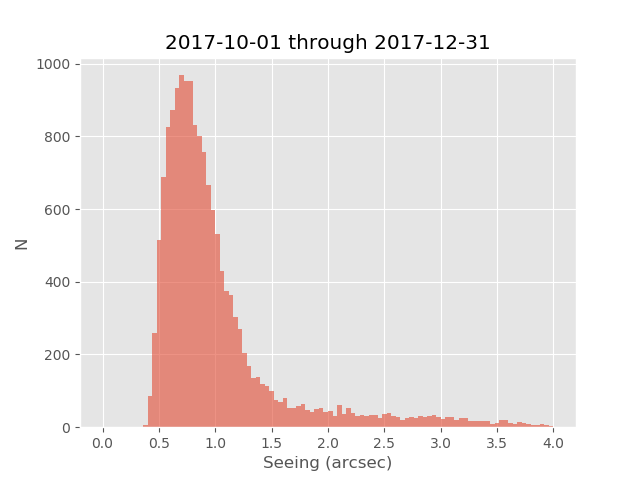

In [175]:
# make raw histogram of the zenith-corrected seeing column
fixed.hist(column='seeing', bins=100, range=(0.0, 4.0), alpha=0.6)
plt.title("2017-10-01 through 2017-12-31")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
plt.show()

In [188]:
# fit a log-normal distribution to the seeing data
sigma, loc, exp_mu = scipy.stats.lognorm.fit(fixed['seeing'])
print(sigma, loc, exp_mu)
x = np.arange(0.0, 4.0, 0.01)
p = scipy.stats.lognorm.pdf(x, sigma, loc=loc, scale=exp_mu)
mu = np.log(exp_mu)
mode = np.exp(mu - sigma**2) + loc
median = np.nanmedian(fixed['seeing'])
fit_median = exp_mu + loc

0.757965243548 0.370931068028 0.481621345695


<IPython.core.display.Javascript object>


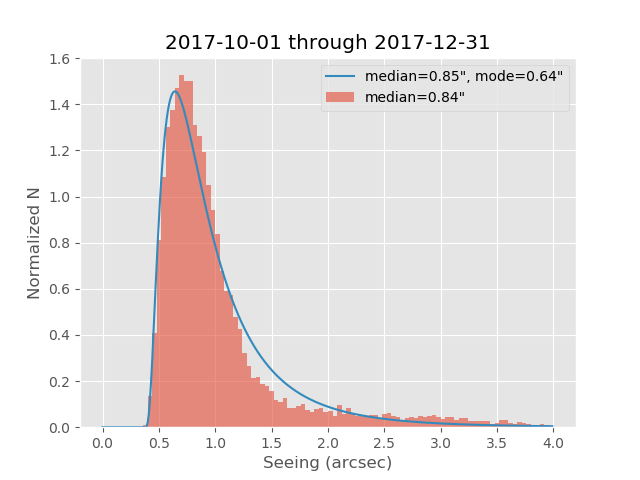

In [191]:
# plot normalized histogram with the fit and the median/mode calculated from the fit.
plt.hist(fixed['seeing'], normed=True, bins=100, range=(0.0, 4.0), label="hist", alpha=0.6)
logp = plt.plot(x, p, label="logp")
plt.xlabel("Seeing (arcsec)")
plt.ylabel("Normalized N")
plt.title("2017-10-01 through 2017-12-31")
plt.legend(["median=%.2f\", mode=%.2f\"" % (fit_median, mode), "median=%.2f\"" % (
    median
)])
plt.savefig("2017q4_hist.pdf")
plt.show()

<IPython.core.display.Javascript object>


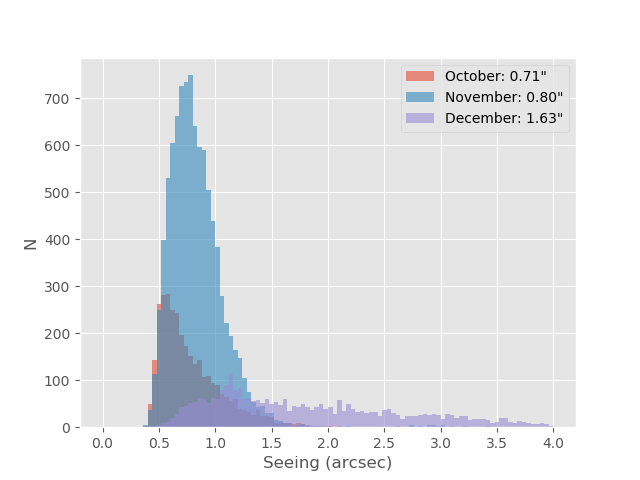

In [192]:
# panda time indexing makes it easy to group by month
months = {}
legends = []
months['October'] = fixed['2017-10']
months['November'] = fixed['2017-11']
months['December'] = fixed['2017-12']
for m in months:
    plt.hist(months[m]['seeing'], bins=100, range=(0.0, 4.0), label=m, alpha=0.6)
    legend = "%s: %.2f\"" % (m, np.median(months[m]['seeing']))
    legends.append(legend)
plt.legend(legends)
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by month")
plt.savefig("2017q4_monthly.pdf")
plt.show()

In [180]:
len(months['October']), len(months['November']), len(months['December'])

(3280, 9472, 3113)

In [181]:
# almost half the total amount of data was from MMIRS in april...
len(fixed)

15865

In [202]:
# now use the between_time() method to split the data into first and second halves of the night.
first_half = fixed.between_time(start_time='00:00', end_time='07:00')
second_half = fixed.between_time(start_time='07:00', end_time='14:00')
first_half = months['December'].between_time(start_time='00:00', end_time='07:00')
second_half = months['December'].between_time(start_time='07:00', end_time='14:00')
med_1st = np.median(first_half['seeing'])
med_2nd = np.median(second_half['seeing'])

<IPython.core.display.Javascript object>


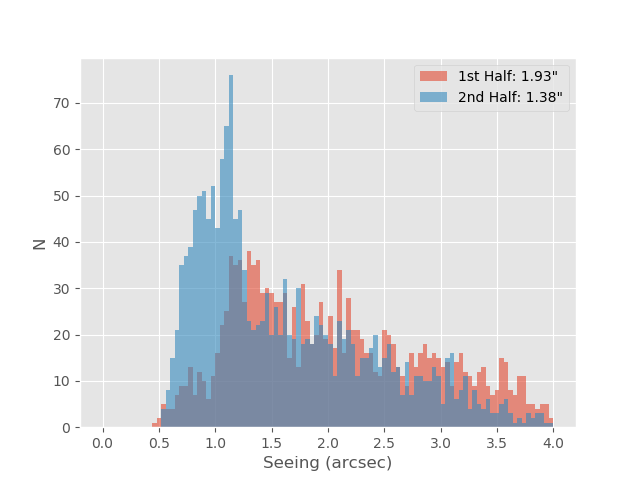

In [203]:
# plot the results and show that the seeing is better later in the night...
plt.hist(first_half['seeing'], bins=100, range=(0.0, 4.0), label="1st", alpha=0.6)
plt.hist(second_half['seeing'], bins=100, range=(0.0, 4.0), label="2nd", alpha=0.6)
plt.legend(["1st Half: %.2f\"" % med_1st, "2nd Half: %.2f\"" % med_2nd])
plt.xlabel("Seeing (arcsec)")
plt.ylabel("N")
#plt.title("Data and median seeing values grouped by half of the night")
plt.savefig("2017dec_1st2nd.pdf")
plt.show()

<IPython.core.display.Javascript object>


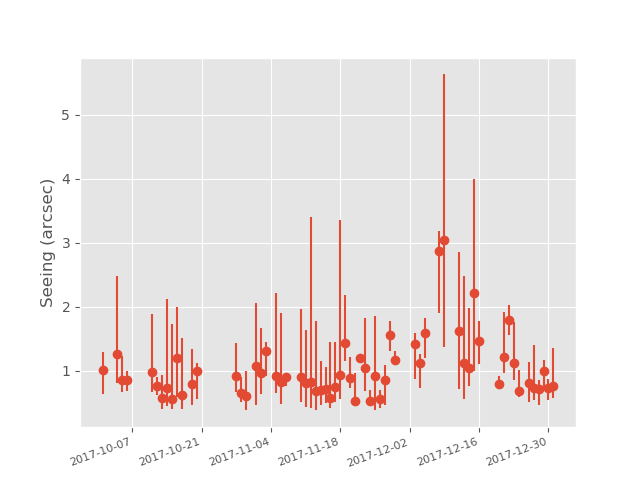

In [196]:
# make a new data frame that resamples the WFS data daily into the median, min, and max seeing for each day.
fig, ax = plt.subplots()
daily = pd.DataFrame()
daily['seeing'] = fixed.seeing.resample('D').median()
daily['max'] = fixed.seeing.resample('D').max()
daily['min'] = fixed.seeing.resample('D').min()
lowb = daily['seeing'] - daily['min']
upb = daily['max'] - daily['seeing']
plt.errorbar(daily.index, daily['seeing'], yerr=[lowb, upb], fmt='o')
labels = ax.get_xticklabels()
plt.setp(labels, rotation=20, fontsize=8, ha='right')
plt.ylabel("Seeing (arcsec)")
#plt.title("Nightly median seeing")
plt.savefig("2017q4_nightly.pdf")
plt.show()

In [127]:
wfs_systems['binospec'].modes['binospec']['reference']['sigma']

0.84932180028801907

In [74]:
wfs_systems['f5'].modes['hecto']['reference']['sigma']

0.96184883977034119

In [75]:
wfs_systems['mmirs'].modes['mmirs2']['reference']['sigma']

0.90580539670604354

In [62]:
wfs_systems['newf9'].modes['blue']['reference']['fwhm']

3.5651174129031213

In [155]:
scipy.stats.lognorm.fit?

In [78]:
from scipy import stats

In [82]:
stats.funcs.gaussian_fwhm_to_sigma

0.42466090014400953